## Steven Miller
## DSC 650
## 2020-02-14

### 10.2 Programming Exercise: Fit a Binary Logistic Regression Model to a Dataset

1. Build a Classification Model

In this exercise, you will fit a binary logistic regression model to the baby name dataset you used in the previous exercise. This model will predict the sex of a person based on their age, name, and state they were born in. To train the model, you will use the data found in baby-names/names-classifier.

a. Prepare in Input Features

First, you will need to prepare each of the input features. While age is a numeric feature, state and name are not. These need to be converted into numeric vectors before you can train the model. Use a StringIndexer along with the OneHotEncoderEstimator to convert the name, state, and sex columns into numeric vectors. Use the VectorAssembler to combine the name, state, and age vectors into a single features vector. Your final dataset should contain a column called features containing the prepared vector and a column called label containing the sex of the person.

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression

spark = SparkSession.builder.appName('Exercise10').getOrCreate()
df = spark.read.parquet("../baby-names/names_classifier/")

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ["state", "name", "sex"]
stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol="sex", outputCol="label")
stages += [label_stringIdx]

numericCols = ["age"]
assemblerInputs = ["stateclassVec","nameclassVec"]+ numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [3]:
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(df)
preppedDataDF = pipelineModel.transform(df)

In [4]:
preppedDataDF.show()

+------+-----+---+---+----------+--------------+---------+-----------------+--------+-------------+-----+--------------------+
|  name|state|sex|age|stateIndex| stateclassVec|nameIndex|     nameclassVec|sexIndex|  sexclassVec|label|            features|
+------+-----+---+---+----------+--------------+---------+-----------------+--------+-------------+-----+--------------------+
|Joseph|   PA|  M| 26|       3.0|(50,[3],[1.0])|      8.0|(31313,[8],[1.0])|     0.0|(1,[0],[1.0])|  0.0|(31364,[3,58,3136...|
|Joseph|   PA|  M| 26|       3.0|(50,[3],[1.0])|      8.0|(31313,[8],[1.0])|     0.0|(1,[0],[1.0])|  0.0|(31364,[3,58,3136...|
|Joseph|   PA|  M| 26|       3.0|(50,[3],[1.0])|      8.0|(31313,[8],[1.0])|     0.0|(1,[0],[1.0])|  0.0|(31364,[3,58,3136...|
|Joseph|   PA|  M| 26|       3.0|(50,[3],[1.0])|      8.0|(31313,[8],[1.0])|     0.0|(1,[0],[1.0])|  0.0|(31364,[3,58,3136...|
|Joseph|   PA|  M| 26|       3.0|(50,[3],[1.0])|      8.0|(31313,[8],[1.0])|     0.0|(1,[0],[1.0])|  0.0|(31364

2. Fit and Evaluate the Model

Fit the model as a logistic regression model with the following parameters. LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8). Provide the area under the ROC curve for the model.

**Using Suggested Parameters**

In [5]:
lrModel = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8).fit(preppedDataDF)

In [6]:
import matplotlib.pyplot as plt

trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

<Figure size 640x480 with 1 Axes>

In [7]:
print('Area Under ROC: ' + str(trainingSummary.areaUnderROC))

Area Under ROC: 0.5


**Using Default Parameters**

In [8]:
lrModel = LogisticRegression(maxIter=10).fit(preppedDataDF)

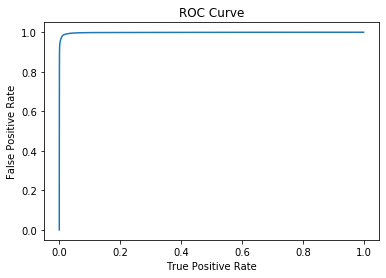

In [9]:
import matplotlib.pyplot as plt

trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [10]:
print('Area Under ROC: ' + str(trainingSummary.areaUnderROC))

Area Under ROC: 0.9984531306956779
